# Capstone Project: Criminal Case Database

### Overall Contents:
- Background
- Webscraping Lawnet
- Webscraping Singapore Statutes
- Natural Language Pocessing
- [Search Function](5.-Search-Function) **(In this notebook)**
- Flask and Google App Engine
- Conclusion and Recommendation

## Datasets

For the search function, I will use the database which I created previously. 

The datasets that I will use are as follows:- 

* database.csv


## 5. Search Function  

The goal of the project is to create a database where users can search for and be shown judgments based on different criteria such as statutes, crimes, or case names.  

Hence it will be necessary to write some functions to allow this searching of the database.  

Regular expressions such as those used in the NLP system will be used as rules to classify the searches to appropriately match within the different columns of the database.

### 5.1 Libraries Import  

I will be using `pandas` to explore the data, `re` for regular expressions, and `matplotlib` for plotting.

In [1]:
# Imports:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
# Increase the max column width
pd.set_option('display.max_colwidth', 300)

### 5.2 Data Import

In [3]:
# Import database of judgments which were processed in the previous notebook.
database = pd.read_csv('../data/database.csv')

In [4]:
database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   case_name              127 non-null    object
 1   tribunal/court         127 non-null    object
 2   decision_date          127 non-null    object
 3   possible_titles        126 non-null    object
 4   possible_statutes      126 non-null    object
 5   citations              122 non-null    object
 6   mitigation_discussed   127 non-null    int64 
 7   aggravation_discussed  127 non-null    int64 
 8   court_tag              127 non-null    object
 9   link                   127 non-null    object
dtypes: int64(2), object(8)
memory usage: 10.0+ KB


### 5.3 Search term conversion  

The first function will convert the `input` string into a standard format to ensure that the search runs smoothly.

This has to first identify the type of search to perform changes to the `input_string` to ensure that it is in an acceptable format.  

It will lower case all input strings and if there is a section number, it will only return the digits with the statute name.

In [5]:
def classify_search(input_string):
    """
    Input: An `input_string` as dtype string
    Output: The `input_string` in lowercase, with `section` or `s` removed from the section portion if available.
    """
    # Check if `input_string` contains `Act` or `Code`
    if re.search('[Aa]ct|[Cc]ode', input_string):
        try:
            # Lowercase the input_string
            section = re.search('(([Ss](ection|)(s|) |)\d+)', input_string.lower()).group(0).strip()
            
            # Remove the section or s portion and return only the digit
            section_num = re.sub('([Ss](ection|)(s|) )', "", section)
        except:
            # If no section number found, just leave it blank
            section_num = ""
            
        # Lowercase the statute name
        statute = re.search(r'((([A-Za-z]*)|(of| )*)*([Aa]ct|[Cc]ode))', input_string.lower()).group(0).strip()
        
        # Combine section number and statute name
        section_statute = section_num + " " + str.lower(statute)
        
        # Return section number and statute name combined
        return section_statute
    
    # If input_string contains `v` within spaces, extract and lowercase the case name.
    elif re.search(' [Vv] ', input_string):
        temp_case_name = re.search('(([A-Za-z]*)(([A-Za-z]*)|(s\/o| |bte|bin|and|another|anr|binti|de|the|for|other|matters))* v (([A-Za-z]*)|(s\/o| |bte|bin|and|another|anr|binti|de|the|for|other|matters))*(?=|))', input_string.lower()).group(0).strip()
        case_name = str.lower(temp_case_name)
        
        # Return the case name
        return case_name
    
    # If other input_string, just lowercase it
    else:
        return str.lower(input_string)

### 5.4 Search algorithm

The search algorithm will first classify the `input_string` accord to the patterns found within to identify which column to perform the search in.  

Next, it will filter to all rows which contain the `input_string` in that column.  

Finally, it returns a resulting dataframe that contains the important columns. The court_tag is not important as that is for the NLP system to run smoothly.

In [9]:
def search_search(input_string):
    """
    Input: An `input_string` as dtype string
    Output: A dataframe of rows from the database which contain the `input_string` in the relevant column.
    """
    # Call the classify_search function to convert the `input_string`
    search_string = classify_search(input_string)
    
    # Load the database
    database = pd.read_csv('../data/database.csv')
    
    # Check if the input_string contains `act` or `code` which classifies it as a statute search and filter the database accordingly
    if re.search('act|code', search_string):
        temp = database.copy().dropna()
        temp1 = temp['possible_statutes'].apply(lambda x: x.lower())
        result = database.loc[list(temp[temp1.str.contains(search_string)].index)]
        return result[['tribunal/court','case_name','decision_date','aggravation_discussed','mitigation_discussed','citations','possible_titles','possible_statutes','link']]
    
    # Check if the input_string contains ` v ` which classifies it as a case_name search and filter the database accordingly
    elif re.search(' v ', search_string):
        temp = database.copy()
        temp1 = temp['case_name'].apply(lambda x: x.lower())
        result = database.loc[list(temp[temp1.str.contains(search_string)].index)]
        return result[['tribunal/court','case_name','decision_date','aggravation_discussed','mitigation_discussed','citations','possible_titles','possible_statutes','link']]
    
    # If it doesn't fit in the above, try searching in all the columns
    else:
        # First check if the input_string is matched in `case_name`
        temp = database.copy()
        temp1 = temp['case_name'].apply(lambda x: x.lower())
        result = database.loc[list(temp[temp1.str.contains(search_string)].index)]
        
        # If no results in `case_name`, search within `possible_offences`
        if len(result) == 0:
            temp = database.copy().dropna()
            temp2 = temp['possible_titles'].apply(lambda x: x.lower())
            result = database.loc[list(temp[temp2.str.contains(search_string)].index)]
            
            # If no results within `possible offences`, search within `possible_statutes`
            if len(result) == 0:
                temp3 = temp['possible_statutes'].apply(lambda x: x.lower())
                result = database.loc[list(temp[temp3.str.contains(search_string)].index)]
                
                # If still no results found, return a `no results found` message.
                if len(result) == 0:
                    print('''No results found.
                    Please ensure your search is in the following format:
                    Case Name (e.g. John v Smith),
                    Part of offence name (e.g. Forgery - try to avoid), or
                    Statute name (e.g. Section 33 Criminal Procedure Code)''')
                else:
                    return result[['tribunal/court','case_name','decision_date','aggravation_discussed','mitigation_discussed','citations','possible_titles','possible_statutes','link']]
            else:
                return result[['tribunal/court','case_name','decision_date','aggravation_discussed','mitigation_discussed','citations','possible_titles','possible_statutes','link']]
        else:
            return result[['tribunal/court','case_name','decision_date','aggravation_discussed','mitigation_discussed','citations','possible_titles','possible_statutes','link']]

### 5.5 Search statistics  

The final function created is to return the relevant statistics from the filtered results of the search.  

The statistics which I have come up with are:  
- `mitigation_rate`: The mean of `mitigation_discussed` for the search  
- `aggravated_rate`: The mean of `aggravation_discussed` for the search  
- `top cited cases`: The top 10 cited cases for this search.  

For the `mitigation_rate` and `aggravated_rate`, this is simply done by finding the means of these two columns as they are binary.  

For the `top cited cases`, this is achieved by splitting the values in the `citations` column for the search results and dummifying the resulting values. This results in columns where the the sum of each case cited can be found, to find out which are the top cited cases.  

This is then used to plot a horizontal bar plot to visualize the `top cited cases`.

In [10]:
def search_statistics(input_string):
    """
    Input: `input_string` as dtype string.
    Output: `mitigation_rate` as a percentage, `aggravated_rate` as a percentage, `top cited cases`,
    `results` dataframe containing filtered results of the search, plot of `top cited cases`
    """
    # Create variable for the results of the search_search function
    results = search_search(input_string)
    results = results.reset_index(drop=True)
    
    # Calculate mean of `mitigation_discussed` to find `mitigation_rate`
    mitigation_rate = results.mitigation_discussed.mean()
    
    # Calculate mean of `aggravation_discussed` to find `aggravated_rate`
    aggravated_rate = results.aggravation_discussed.mean()
    
    # Create citations dataframe
    citations = pd.DataFrame(results['citations'])
    
    # Split the values of the `citations` column
    citations['citations'] = citations['citations'].apply(lambda x: x.split(','))
    
    # Dummify the columns of the split results.
    citations2 = pd.DataFrame(pd.get_dummies(citations['citations'].apply(pd.Series).stack()).sum(level=0))
    
    # Print the statistics
    print(f'''Mitigating factors were discussed in {mitigation_rate*100}% of the cases for this search.
Aggravating factors were discussed in {aggravated_rate*100}% of the cases for this search.

The top cited cases for this search are: 
{citations2.sum().sort_values(ascending=False).head(10)}''')
    
    # Create a plot for the `top cited cases`
    plt.figure(figsize = (10,8))
    citations2.sum().sort_values(ascending=False).head(10)[::-1].plot(kind='barh')
    plt.title('Most cited cases in this search')
    plt.xlabel('Frequency (expressed as decimal)')
    
    # Save the plot
    plt.savefig('../images/search.png', bbox_inches='tight')

    # Return results
    return results

### 5.6 Testing the functions  

I will test the functions above on a sample input string "FORGERY"

Mitigating factors were discussed in 80.0% of the cases for this search.
Aggravating factors were discussed in 60.0% of the cases for this search.

The top cited cases for this search are: 
Xia Qin Lai v Public Prosecutor                1
PP v Siti Safiah Binte Mohamed Alifah          1
Lim Chu Bok v Public Prosecutor                1
Lim Ek Kian v Public Prosecutor                1
Mohamed Shouffee bin Adam v PP                 1
PP v Agnes Tan Mei Qing                        1
PP v Fernando Payagala Waduge Malitha Kumar    1
PP v Gan Chai Bee Anne                         1
PP v Lee Chee Siang                            1
PP v Malinda Wongpipatkasem                    1
dtype: int64


,tribunal/court,case_name,decision_date,aggravation_discussed,mitigation_discussed,citations,possible_titles,possible_statutes,link
0,Court of Appeal,Tang Keng Lai v Public Prosecutor [2021] SGCA 52,11 May 2021,0,0,"Public Prosecutor v Tang Keng Lai and another,Public Prosecutor v GCK and another,Public Prosecutor v Teo Chu Ha,Huang Liping v Public Prosecutor","Criminal breach of trust by public servant, or by banker, merchant, agent, director, officer, partner, key executive or fiduciary,Robbery when armed or with attempt to cause death or grievous hurt,Assault or criminal force in attempting wrongfully to confine a person,Not in database,Punishment f...","397 Criminal Procedure Code,397 Penal Code,409 Criminal Procedure Code,409 Penal Code,357 Criminal Procedure Code,357 Penal Code,465 Criminal Procedure Code,465 Penal Code,471 Criminal Procedure Code,471 Penal Code,109 Criminal Procedure Code,109 Penal Code",https://www.lawnet.sg/lawnet/web/lawnet/free-resources?p_p_id=freeresources_WAR_lawnet3baseportlet&p_p_lifecycle=1&p_p_state=normal&p_p_mode=view&p_p_col_id=column-1&p_p_col_pos=2&p_p_col_count=3&_freeresources_WAR_lawnet3baseportlet_action=openContentPage&_freeresources_WAR_lawnet3baseportlet_d...
1,District Court,"Public Prosecutor v Yong Wei Onn, Louis Paul [2021] SGDC 33",17 February 2021,1,1,"PP v Fernando Payagala Waduge Malitha Kumar,Lim Ek Kian v Public Prosecutor,Public Prosecutor v Lee Chee Siang,Lim Chu Bok v Public Prosecutor,Public Prosecutor v Mazlan bin Duaji,Public Prosecutor v Kwa Tian Hwa,PP v Lee Chee Siang",Forgery for the purpose of cheating,468 Penal Code,https://www.lawnet.sg/lawnet/web/lawnet/free-resources?p_p_id=freeresources_WAR_lawnet3baseportlet&p_p_lifecycle=1&p_p_state=normal&p_p_mode=view&p_p_col_id=column-1&p_p_col_pos=2&p_p_col_count=3&_freeresources_WAR_lawnet3baseportlet_action=openContentPage&_freeresources_WAR_lawnet3baseportlet_d...
2,District Court,Public Prosecutor v Ang Wee Hong [2021] SGDC 60,26 March 2021,1,1,"PP v Sani bin Mohamed Salim,PP v Martin Raymond Tua Pardede,PP v Agnes Tan Mei Qing,PP v Malinda Wongpipatkasem,PP v Noriza Binte Aziz,PP v Siti Safiah Binte Mohamed Alifah,Public Prosecutor v Chen Young Ja,PP v Gan Chai Bee Anne,Soong Hee Sin v PP,Mohamed Shouffee bin Adam v PP","Theft by clerk or servant of property in possession of master,Theft in dwelling-house, etc.,Punishment for theft,Cheating and dishonestly inducing a delivery of property,Forgery of a valuable security or will","379 Penal Code,381 Penal Code,467 Penal Code,420 Penal Code,380 Penal Code",https://www.lawnet.sg/lawnet/web/lawnet/free-resources?p_p_id=freeresources_WAR_lawnet3baseportlet&p_p_lifecycle=1&p_p_state=normal&p_p_mode=view&p_p_col_id=column-1&p_p_col_pos=2&p_p_col_count=3&_freeresources_WAR_lawnet3baseportlet_action=openContentPage&_freeresources_WAR_lawnet3baseportlet_d...
3,District Court,Public Prosecutor v M Akbar Bin Mohamed Ibrahim [2021] SGDC 61,29 March 2021,0,1,"PP v Osi Maria Elenora Protacio,PP v Ong Yew Hien","Kidnapping,Punishment of criminal breach of trust,Not in database,Punishment for forgery,Cheating and dishonestly inducing a delivery of property","406 Criminal Procedure Code,406 Penal Code,406 Bankruptcy Act,14 Criminal Procedure Code,14 Penal Code,14 Bankruptcy Act,465 Criminal Procedure Code,465 Penal Code,465 Bankruptcy Act,420 Criminal Procedure Code,420 Penal Code,420 Bankruptcy Act,359 Criminal Procedure Code,359 Penal Code,359 Bank...",https://www.lawnet.sg/lawnet/web/lawnet/free-resources?p_p_id=freeresources_WAR_lawnet3baseportlet&p_p_lifecycle=1&p_p_state=normal&p_p_mode=view&p_p_col_id=column-1&p_p_col_pos=2&p_p_col_count=3&_freeresources_WAR_lawnet3baseportlet_action=openContentPage&_freeresources_WAR_lawnet3baseportlet_d...
4,District Court,Public Prosecutor v Lee Xiu Qi [2021] SGDC 77,18 May 2021,1,1,"Tay Boon Hui Freddy v Public Prosecutor,Xia Qin Lai v Public Prosecutor,Public Prosecutor v Younis Adnan Mohammed,Public Prosecutor v Ho Wei Chuan,Public Pr

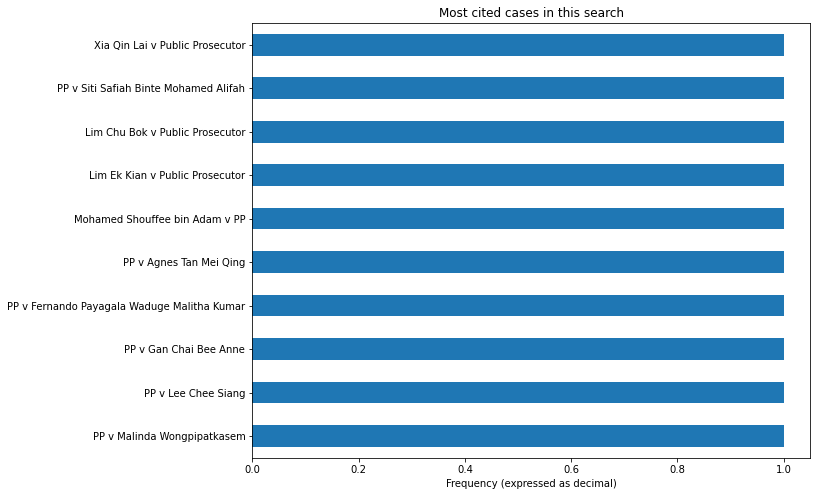

In [11]:
input_string = 'FORGERY'
search_statistics(input_string)

## Observations  

The functions seem to work well and the expected statistics, dataframe, and plot are returned. The results all contain the word `forgery` in the `possible_offences`, which is the correct column.  

Hence the search engine seems to be a success.